In [17]:
import spacy
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

# Cargar modelo en español de spaCy
nlp = spacy.load("es_core_news_sm")

# Lista de palabras clave
keywords = ['lluvia', 'inundación', 'accidente', 'apagón', 'deslave', 'desborde', 'incendio', 'fuga', 'colapso', 'tormenta']

# Función para eliminar los símbolos, emoticones y links
def clean_text(text):
    text = re.sub(r'http\S+|www.\S+', '', text)
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F700-\U0001F77F"  
        u"\U0001F780-\U0001F7FF"  
        u"\U0001F800-\U0001F8FF"  
        u"\U0001F900-\U0001F9FF"  
        u"\U0001FA00-\U0001FA6F"  
        u"\U0001FA70-\U0001FAFF"  
        u"\U00002700-\U000027BF"  
        u"\U0001F1E0-\U0001F1FF"  
        "]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑüÜ\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Función para verificar si el tweet contiene una palabra clave o sus variantes
def contains_keyword(text, keywords, nlp):
    doc = nlp(text)
    lemmas = {token.lemma_ for token in doc}
    return any(keyword in lemmas for keyword in keywords)

# Cargar la base de datos
tweets_file = "/Users/Daniel/Documents/ITESM/Séptimo Semestre/proyecto nlp/Predicci-n-de-Riesgos-Urbanos-con-NLP/X-NLP/tweets_Jun22-1.csv"
df_tweets = pd.read_csv(tweets_file)

# Eliminar tweets que no tienen texto
df_tweets_clean = df_tweets.dropna(subset=['Texto'])

# Aplicar la función de limpieza a la columna de texto 
df_tweets_clean['Texto'] = df_tweets_clean['Texto'].apply(clean_text)

# Filtrar los tweets que contienen una palabra clave o sus variantes
df_tweets_filtered = df_tweets_clean[df_tweets_clean['Texto'].apply(lambda x: contains_keyword(x, keywords, nlp))]

# Guardar el resultado filtrado
df_tweets_filtered.to_csv('/Users/Daniel/Documents/ITESM/Séptimo Semestre/proyecto nlp/Predicci-n-de-Riesgos-Urbanos-con-NLP/X-NLP/tweets_Jun_filtered/tweets_Jun22-1_filtered.csv', index=False)


/var/folders/8b/d34q145x44x2xf_06_gchyfw0000gq/T/ipykernel_71386/523724659.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_clean['Texto'] = df_tweets_clean['Texto'].apply(clean_text)


## Unificando datasets en un solo dataframe

In [ ]:
import os
import pandas as pd

# Directorio donde se encuentran los CSV
folder_path = '/Users/Daniel/Documents/ITESM/Séptimo Semestre/proyecto nlp/Predicci-n-de-Riesgos-Urbanos-con-NLP/X-NLP/tweets_Jun_filtered'

# Lista para almacenar los DataFrames
df_list = []

# Iterar sobre los archivos en el directorio
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        # Cargar cada CSV en un DataFrame y añadirlo a la lista
        df = pd.read_csv(os.path.join(folder_path, filename))
        df_list.append(df)

# Concatenar todos los DataFrames de la lista en uno solo
combined_df = pd.concat(df_list, ignore_index=True)

# Guardar el DataFrame combinado en un nuevo archivo CSV
combined_df.to_csv('tweets_filtered_global.csv', index=False)

print('CSV combinados y guardados como archivo_combinado.csv')


## Cargando dataset etiquetado para entrenar modelo

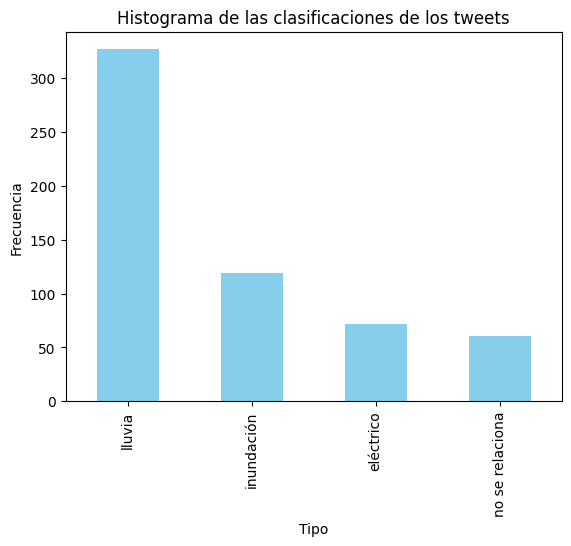

In [3]:
tweets_clean_classified = "tweets_better_classified.csv"
df_tweets_clean_fil = pd.read_csv(tweets_clean_classified)

tipo_counts = df_tweets_clean_fil['Tipo'].value_counts()

# Creación del histograma
tipo_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Tipo')
plt.ylabel('Frecuencia')
plt.title('Histograma de las clasificaciones de los tweets')
plt.show()

## Modelo de clasificación de tweets

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch

In [8]:
# Cargar el dataset
df = pd.read_csv("tweets_better_classified.csv")

# Preprocesar las etiquetas
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Tipo'])  # Ajusta 'categoria' a la columna correspondiente

# Dividir el dataset en entrenamiento y prueba
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Inicializar el tokenizer BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Función para tokenizar los textos
def tokenize_function(examples):
    return tokenizer(examples['Texto'], padding="max_length", truncation=True, max_length=128)

# Aplicar el tokenizer a los datos de entrenamiento y prueba
train_encodings = tokenizer(list(train['Texto'].values), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test['Texto'].values), truncation=True, padding=True, max_length=128)

# Convertir las etiquetas en tensores
train_labels = torch.tensor(train['label'].values)
test_labels = torch.tensor(test['label'].values)

# Crear un dataset personalizado
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

# Cargar el modelo BERT para clasificación de secuencias
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)  

# Definir los argumentos del entrenamiento
training_args = TrainingArguments(
    output_dir='./results',          # Directorio para guardar los resultados
    num_train_epochs=10,              # Número de épocas
    per_device_train_batch_size=16,  # Tamaño del lote en entrenamiento
    per_device_eval_batch_size=64,   # Tamaño del lote en evaluación
    warmup_steps=500,                # Número de pasos para warmup
    weight_decay=0.01,               # Tasa de decaimiento del peso
    logging_dir='./logs',            # Directorio para guardar los logs
    logging_steps=10,
)

# Crear el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Entrenar el modelo
trainer.train()

# Evaluar el modelo
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Reporte de clasificación
print(classification_report(test_labels, preds, target_names=label_encoder.classes_))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  3%|▎         | 10/290 [01:52<53:17, 11.42s/it] 

{'loss': 1.4366, 'grad_norm': 8.068428039550781, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.34}


  7%|▋         | 20/290 [04:10<1:03:08, 14.03s/it]

{'loss': 1.4012, 'grad_norm': 6.48807954788208, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.69}


 10%|█         | 30/290 [06:26<1:02:04, 14.32s/it]

{'loss': 1.321, 'grad_norm': 4.925544261932373, 'learning_rate': 3e-06, 'epoch': 1.03}


 14%|█▍        | 40/290 [08:42<57:27, 13.79s/it]  

{'loss': 1.2342, 'grad_norm': 4.948869705200195, 'learning_rate': 4.000000000000001e-06, 'epoch': 1.38}


 17%|█▋        | 50/290 [10:59<52:06, 13.03s/it]  

{'loss': 1.1332, 'grad_norm': 7.89774227142334, 'learning_rate': 5e-06, 'epoch': 1.72}


 21%|██        | 60/290 [13:00<45:40, 11.92s/it]

{'loss': 1.092, 'grad_norm': 9.240959167480469, 'learning_rate': 6e-06, 'epoch': 2.07}


 24%|██▍       | 70/290 [15:10<46:04, 12.57s/it]

{'loss': 1.0998, 'grad_norm': 7.956357002258301, 'learning_rate': 7.000000000000001e-06, 'epoch': 2.41}


 28%|██▊       | 80/290 [17:22<42:36, 12.17s/it]

{'loss': 0.9436, 'grad_norm': 9.090806007385254, 'learning_rate': 8.000000000000001e-06, 'epoch': 2.76}


 31%|███       | 90/290 [19:39<46:07, 13.84s/it]

{'loss': 0.8908, 'grad_norm': 6.102569580078125, 'learning_rate': 9e-06, 'epoch': 3.1}


 34%|███▍      | 100/290 [21:27<30:47,  9.72s/it]

{'loss': 0.7171, 'grad_norm': 9.406201362609863, 'learning_rate': 1e-05, 'epoch': 3.45}


 38%|███▊      | 110/290 [23:25<35:10, 11.72s/it]

{'loss': 0.8744, 'grad_norm': 8.811043739318848, 'learning_rate': 1.1000000000000001e-05, 'epoch': 3.79}


 41%|████▏     | 120/290 [25:28<33:10, 11.71s/it]

{'loss': 0.7032, 'grad_norm': 5.637996673583984, 'learning_rate': 1.2e-05, 'epoch': 4.14}


 45%|████▍     | 130/290 [27:42<33:38, 12.62s/it]

{'loss': 0.5137, 'grad_norm': 8.632944107055664, 'learning_rate': 1.3000000000000001e-05, 'epoch': 4.48}


 48%|████▊     | 140/290 [29:32<26:42, 10.69s/it]

{'loss': 0.4598, 'grad_norm': 6.459730625152588, 'learning_rate': 1.4000000000000001e-05, 'epoch': 4.83}


 52%|█████▏    | 150/290 [31:38<31:43, 13.60s/it]

{'loss': 0.3989, 'grad_norm': 14.099217414855957, 'learning_rate': 1.5e-05, 'epoch': 5.17}


 55%|█████▌    | 160/290 [33:42<27:10, 12.54s/it]

{'loss': 0.4191, 'grad_norm': 30.662748336791992, 'learning_rate': 1.6000000000000003e-05, 'epoch': 5.52}


 59%|█████▊    | 170/290 [35:46<26:11, 13.10s/it]

{'loss': 0.3722, 'grad_norm': 1.1918506622314453, 'learning_rate': 1.7000000000000003e-05, 'epoch': 5.86}


 62%|██████▏   | 180/290 [37:34<17:47,  9.70s/it]

{'loss': 0.1826, 'grad_norm': 6.8704304695129395, 'learning_rate': 1.8e-05, 'epoch': 6.21}


 66%|██████▌   | 190/290 [39:03<14:46,  8.86s/it]

{'loss': 0.237, 'grad_norm': 4.635956764221191, 'learning_rate': 1.9e-05, 'epoch': 6.55}


 69%|██████▉   | 200/290 [40:48<14:52,  9.92s/it]

{'loss': 0.1788, 'grad_norm': 8.922293663024902, 'learning_rate': 2e-05, 'epoch': 6.9}


 72%|███████▏  | 210/290 [42:53<17:43, 13.29s/it]

{'loss': 0.1641, 'grad_norm': 1.600313663482666, 'learning_rate': 2.1e-05, 'epoch': 7.24}


 76%|███████▌  | 220/290 [44:52<13:30, 11.58s/it]

{'loss': 0.1259, 'grad_norm': 15.667215347290039, 'learning_rate': 2.2000000000000003e-05, 'epoch': 7.59}


 79%|███████▉  | 230/290 [46:28<09:49,  9.83s/it]

{'loss': 0.0549, 'grad_norm': 0.3655213415622711, 'learning_rate': 2.3000000000000003e-05, 'epoch': 7.93}


 83%|████████▎ | 240/290 [48:34<10:27, 12.54s/it]

{'loss': 0.09, 'grad_norm': 0.3416174054145813, 'learning_rate': 2.4e-05, 'epoch': 8.28}


 86%|████████▌ | 250/290 [50:40<08:14, 12.37s/it]

{'loss': 0.05, 'grad_norm': 0.1444886326789856, 'learning_rate': 2.5e-05, 'epoch': 8.62}


 90%|████████▉ | 260/290 [52:54<07:13, 14.45s/it]

{'loss': 0.0603, 'grad_norm': 1.2603914737701416, 'learning_rate': 2.6000000000000002e-05, 'epoch': 8.97}


 93%|█████████▎| 270/290 [54:56<04:07, 12.37s/it]

{'loss': 0.1724, 'grad_norm': 2.8948917388916016, 'learning_rate': 2.7000000000000002e-05, 'epoch': 9.31}


 97%|█████████▋| 280/290 [56:44<01:45, 10.59s/it]

{'loss': 0.0933, 'grad_norm': 0.11398879438638687, 'learning_rate': 2.8000000000000003e-05, 'epoch': 9.66}


100%|██████████| 290/290 [58:39<00:00, 12.14s/it]


{'loss': 0.0073, 'grad_norm': 0.5522570013999939, 'learning_rate': 2.9e-05, 'epoch': 10.0}
{'train_runtime': 3519.2527, 'train_samples_per_second': 1.316, 'train_steps_per_second': 0.082, 'train_loss': 0.5664509480883335, 'epoch': 10.0}


100%|██████████| 2/2 [00:09<00:00,  4.82s/it]


                 precision    recall  f1-score   support

      eléctrico       0.94      0.94      0.94        17
     inundación       0.95      1.00      0.98        21
         lluvia       0.99      0.99      0.99        67
no se relaciona       1.00      0.91      0.95        11

       accuracy                           0.97       116
      macro avg       0.97      0.96      0.96       116
   weighted avg       0.97      0.97      0.97       116



# Guardando Modelo entrenado

In [9]:
model.save_pretrained('./my_model')
tokenizer.save_pretrained('./my_model')

('./my_model/tokenizer_config.json',
 './my_model/special_tokens_map.json',
 './my_model/vocab.txt',
 './my_model/added_tokens.json')

## Cargando modelo y clasificando

In [6]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Cargar el tokenizador y el modelo
tokenizer = BertTokenizer.from_pretrained('./my_model')
model = BertForSequenceClassification.from_pretrained('./my_model')

# Cargar el LabelEncoder (Asegúrate de que es el mismo usado durante el entrenamiento)
df_original = pd.read_csv("tweets_better_classified.csv")  # Dataset original para recuperar las etiquetas
label_encoder = LabelEncoder()
label_encoder.fit(df_original['Tipo'])  # Ajusta 'Tipo' a la columna de etiquetas original

# Cargar el dataset filtrado
df_filtered = pd.read_csv("tweets_globales_filtrados.csv")

# Define una función para predecir nuevos textos
def predict_new_text(text):
    # Tokenizar el texto
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

    # Asegúrate de mover el modelo y los inputs a la GPU si está disponible
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Hacer la predicción
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Obtener la clase predicha
    predicted_class = torch.argmax(logits, dim=1).item()

    # Decodificar la etiqueta predicha
    predicted_label = label_encoder.inverse_transform([predicted_class])

    return predicted_label[0]

# Predecir etiquetas para la columna 'texto' y almacenarlas en una nueva columna 'Tipo'
df_filtered['Tipo'] = df_filtered['Texto'].apply(predict_new_text)

# Guardar el nuevo DataFrame en un archivo CSV
df_filtered.to_csv("tweets_globales_clasificados.csv", index=False)

print("Archivo 'tweets_classified.csv' guardado con las etiquetas predichas.")


OSError: Error no file named pytorch_model.bin, model.safetensors, tf_model.h5, model.ckpt.index or flax_model.msgpack found in directory ./my_model.

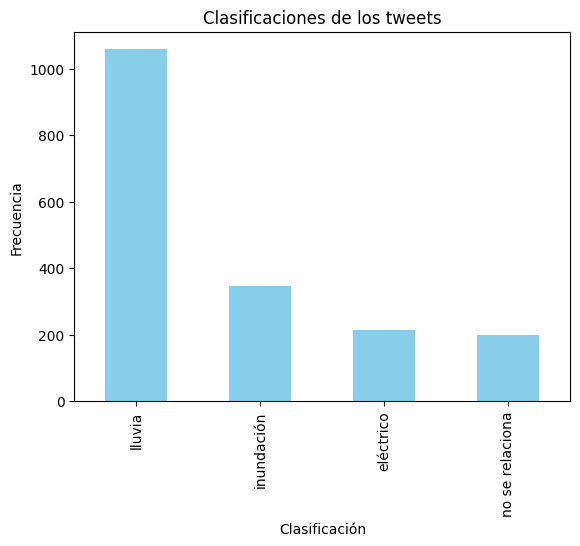

In [32]:
tweets_clean_classified = "tweets_classified.csv"
df_tweets_clean_fil = pd.read_csv(tweets_clean_classified)

tipo_counts = df_tweets_clean_fil['Tipo'].value_counts()

# Creación del histograma
tipo_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Clasificación')
plt.ylabel('Frecuencia')
plt.title('Clasificaciones de los tweets')
plt.show()

In [31]:
classified = pd.read_csv('tweets_classified.csv')
classified=classified[['Texto', 'Tipo']]

In [16]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
import spacy

# Descargar stopwords en español
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

# Cargar el modelo de spaCy para español
nlp = spacy.load('es_core_news_sm')

# Cargar el dataset
df = pd.read_csv('tweets_filtered_global.csv')

# Función para preprocesar el texto
def preprocess_text(text):
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar puntuación
    return text

# Función para lematizar y eliminar stopwords
def lemmatize_and_remove_stopwords(text):
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_punct]
    return lemmatized_words

# Concatenar todos los textos en una sola cadena
all_texts = ' '.join(df['Texto'].astype(str))

# Preprocesar el texto
processed_text = preprocess_text(all_texts)

# Lematizar y eliminar stopwords
lemmatized_words = lemmatize_and_remove_stopwords(processed_text)

# Contar las raíces de las palabras
word_counts = Counter(lemmatized_words)

# Mostrar las palabras más comunes
for word, count in word_counts.most_common(50):  # Muestra las 10 palabras más comunes
    print(f'{word}: {count}')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


lluvia: 1261
alberto: 400
zona: 375
inundación: 372
monterrey: 270
fuerte: 261
nl: 257
incendio: 234
precaución: 226
nuevo: 210
presa: 203
mm: 202
av: 199
accidente: 197
reporte: 197
almacenamiento: 195
león: 188
atender: 179
día: 161
tormenta: 149
reportar: 143
santa: 142
estación: 140
spgg: 138
bombero: 130
agua: 128
boca: 127
río: 124
colonia: 120
altura: 120
catarina: 117
medio: 117
seguir: 116
san: 112
próximo: 110
tras: 109
información: 106
riesgo: 106
intenso: 104
hora: 104
vial: 102
civil: 101
bajo: 100
así: 99
nivel: 99
sur: 97
prieto: 97
pcsp: 96
encontrar: 95
avenida: 95


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


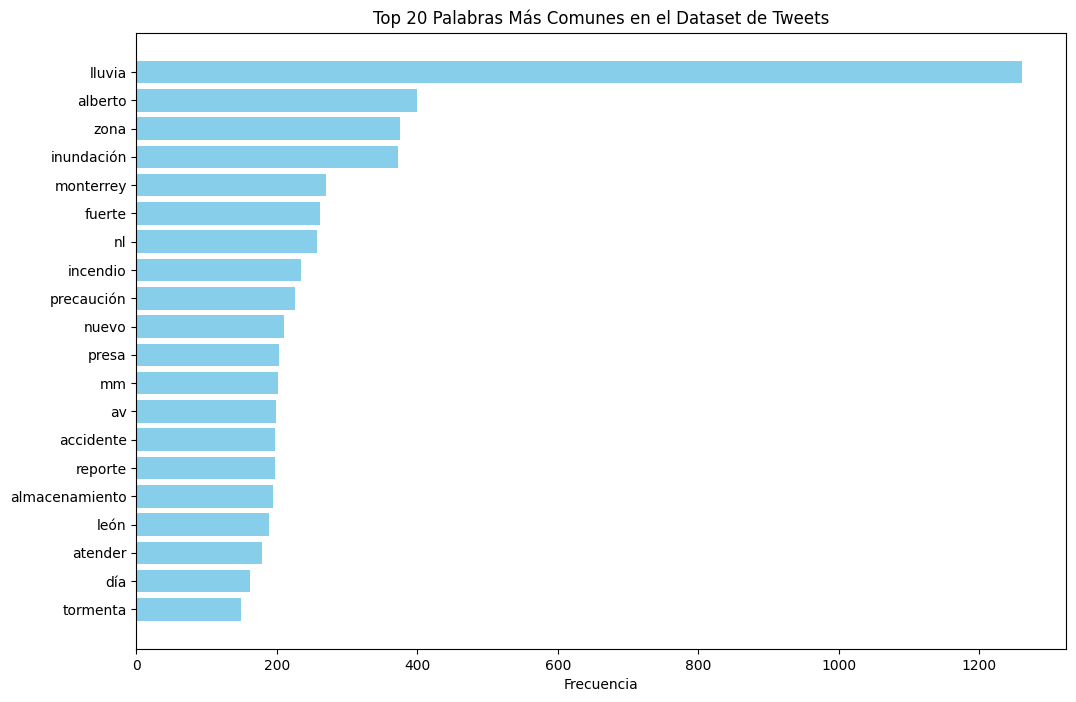

In [20]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
import spacy
import matplotlib.pyplot as plt

# Descargar stopwords en español
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

# Cargar el modelo de spaCy para español
nlp = spacy.load('es_core_news_sm')

# Cargar el dataset
df = pd.read_csv('tweets_filtered_global.csv')

# Función para preprocesar el texto
def preprocess_text(text):
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar puntuación
    return text

# Función para lematizar y eliminar stopwords
def lemmatize_and_remove_stopwords(text):
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_punct]
    return lemmatized_words

# Concatenar todos los textos en una sola cadena
all_texts = ' '.join(df['Texto'].astype(str))

# Preprocesar el texto
processed_text = preprocess_text(all_texts)

# Lematizar y eliminar stopwords
lemmatized_words = lemmatize_and_remove_stopwords(processed_text)

# Contar las raíces de las palabras
word_counts = Counter(lemmatized_words)

# Mostrar las palabras más comunes
most_common_words = word_counts.most_common(20)  # Muestra las 50 palabras más comunes

# Preparar datos para la gráfica
words, counts = zip(*most_common_words)

# Crear la gráfica
plt.figure(figsize=(12, 8))
plt.barh(words, counts, color='skyblue')
plt.xlabel('Frecuencia')
plt.title('Top 20 Palabras Más Comunes en el Dataset de Tweets')
plt.gca().invert_yaxis()  # Para que la palabra más frecuente esté en la parte superior
plt.show()


# Calificando

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch

/Users/Daniel/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/Daniel/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-05 11:49:13.939041: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:

# Cargar el dataset
df = pd.read_csv("daño_tweets_22.csv")

# Convertir los datos de la columna 'Nivel' a strings
df['Nivel'] = df['Nivel'].astype(str)

# Luego, procede con la codificación de etiquetas
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Nivel']) 


# Dividir el dataset en entrenamiento y prueba
train, test = train_test_split(df, test_size=0.3, random_state=42)

# Inicializar el tokenizer BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Función para tokenizar los textos
def tokenize_function(examples):
    return tokenizer(examples['Texto'], padding="max_length", truncation=True, max_length=128)

# Aplicar el tokenizer a los datos de entrenamiento y prueba
train_encodings = tokenizer(list(train['Texto'].values), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test['Texto'].values), truncation=True, padding=True, max_length=128)

# Convertir las etiquetas en tensores
train_labels = torch.tensor(train['label'].values)
test_labels = torch.tensor(test['label'].values)

# Crear un dataset personalizado
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

# Cargar el modelo BERT para clasificación de secuencias
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)  

# Definir los argumentos del entrenamiento
training_args = TrainingArguments(
    output_dir='./results',          # Directorio para guardar los resultados
    num_train_epochs=5,              # Número de épocas
    per_device_train_batch_size=16,  # Tamaño del lote en entrenamiento
    per_device_eval_batch_size=64,   # Tamaño del lote en evaluación
    warmup_steps=500,                # Número de pasos para warmup
    weight_decay=0.01,               # Tasa de decaimiento del peso
    logging_dir='./logs',            # Directorio para guardar los logs
    logging_steps=10,
)

# Crear el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Entrenar el modelo
trainer.train()

# Evaluar el modelo
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Reporte de clasificación
print(classification_report(test_labels, preds, target_names=label_encoder.classes_))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 14%|█▍        | 10/70 [03:27<24:42, 24.71s/it]

{'loss': 1.3334, 'grad_norm': 3.4261844158172607, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.71}


 29%|██▊       | 20/70 [06:17<13:14, 15.88s/it]

{'loss': 1.3588, 'grad_norm': 4.824686050415039, 'learning_rate': 2.0000000000000003e-06, 'epoch': 1.43}


 43%|████▎     | 30/70 [07:58<06:23,  9.60s/it]

{'loss': 1.3124, 'grad_norm': 4.040501594543457, 'learning_rate': 3e-06, 'epoch': 2.14}


 57%|█████▋    | 40/70 [09:35<05:04, 10.14s/it]

{'loss': 1.3084, 'grad_norm': 9.327106475830078, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.86}


 71%|███████▏  | 50/70 [10:58<02:48,  8.41s/it]

{'loss': 1.2867, 'grad_norm': 4.351668357849121, 'learning_rate': 5e-06, 'epoch': 3.57}


 86%|████████▌ | 60/70 [12:17<01:18,  7.86s/it]

{'loss': 1.2414, 'grad_norm': 6.379819869995117, 'learning_rate': 6e-06, 'epoch': 4.29}


100%|██████████| 70/70 [13:34<00:00, 11.64s/it]


{'loss': 1.2066, 'grad_norm': 11.151424407958984, 'learning_rate': 7.000000000000001e-06, 'epoch': 5.0}
{'train_runtime': 814.3496, 'train_samples_per_second': 1.314, 'train_steps_per_second': 0.086, 'train_loss': 1.2925269535609654, 'epoch': 5.0}


100%|██████████| 2/2 [00:03<00:00,  1.93s/it]


              precision    recall  f1-score   support

           1       0.57      0.77      0.66        30
           2       0.49      0.79      0.60        33
           3       0.00      0.00      0.00        19
           4       0.00      0.00      0.00        11

    accuracy                           0.53        93
   macro avg       0.27      0.39      0.32        93
weighted avg       0.36      0.53      0.43        93



/Users/Daniel/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Daniel/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Daniel/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu